# Stock Analysis Using LSTM - MVP (LATEST)
- train an LSTM on a variable number of features
- vary on lookback (LSTM window) and training window (years before present date)
- multi input version
- multi day lookahead (predict x days ahead) version

This notebook adapted from https://www.kaggle.com/faressayah/stock-market-analysis-prediction-using-lstm

# Import required libraries and set up notebook


In [877]:
! python --version

Python 3.7.4


In [878]:
! pip install quandl
#! pip install pip --upgrade
#! pip install pandas-datareader
print("past pandas_datareader")
#! pip install yahoo_fin
import pandas as pd
import numpy as np
import os
import yaml
from datetime import date
import requests

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

# For reading stock data from yahoo
#import pandas_datareader as pdr
from pandas_datareader.data import DataReader
# import yahoo_fin.stock_info as si

# For time stamps
from datetime import datetime

# for LSTM
from keras.models import Sequential
from keras.layers import Dense, LSTM, Input
from keras.models import Model
# from tensorflow.keras.layers import Input, Dropout, Dense, BatchNormalization, Activation, concatenate, GRU, Embedding, Flatten, BatchNormalization
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import load_model
# access datasets from quandl.com - need to pip install Quandl to use
import quandl
on_colab = False
verboseout = True
look_back = 3
config_file = 'model_training_config.yml'

In [879]:
import tensorflow as tf
tf.__version__

'1.15.0'

In [880]:
'''
r = requests.get('https://finnhub.io/api/v1/stock/dividend2?symbol=AAPL&token=c16hj0f48v6ppg7erf7g')
print(r.json())
'''

"\nr = requests.get('https://finnhub.io/api/v1/stock/dividend2?symbol=AAPL&token=c16hj0f48v6ppg7erf7g')\nprint(r.json())\n"

In [881]:
start_timestamp = datetime.now()
if on_colab:
    from google.colab import drive
    drive.mount('/content/drive')

In [882]:
if on_colab:
    %cd /content/drive/MyDrive/karma_jan_2021/stock_investigation/notebooks

# Load config parameters

In [883]:
# load config file
current_path = os.getcwd()
print("current directory is: "+current_path)

path_to_yaml = os.path.join(current_path, config_file)
print("path_to_yaml "+path_to_yaml)
try:
    with open (path_to_yaml, 'r') as c_file:
        config = yaml.safe_load(c_file)
except Exception as e:
    print('Error reading the config file')

current directory is: C:\personal\karma_stocks_2021\stock_investigation\notebooks
path_to_yaml C:\personal\karma_stocks_2021\stock_investigation\notebooks\model_training_config.yml


In [884]:
# switches
repeatable_run = config['general']['repeatable_run']
# fix seeds to get identical results on mulitiple runs
if repeatable_run:
    from numpy.random import seed
    seed(4)
    # dumb switch to make up for dumb regression going from TF 1 to TF 2
    if tf.__version__ == '1.15.0':
        tf.set_random_seed(7)
    else:
        tf.random.set_seed(7)


plot_all = config['general']['verboseout']
use_saved_model = config['general']['presaved']
ust_cols = config['general']['ust_cols']
report_round = config['general']['report_round']
# list of ticket symbols
# e.g. tech_list = ['AAPL', 'GOOG', 'MSFT', 'AMZN']
tech_list = config['tech_list']
# dictionary to seed stock handles with company names
saved_model_modifier = config['files']['saved_model_modifier']
# get the column lists
close_threshold = config['general']['close_threshold']
years_window = config['general']['years_window']
quandl_token = config['general']['quandl_token']
# number of days previous used to predict subsequent day
look_back = config['general']['look_back']
# gap in day betwen the last day previous and the subsequent day being predicted
look_ahead = config['general']['look_ahead']
years_winow = config['general']['years_window']
# target column
lstm_target = config['general']['lstm_target']
# list from target column
lstm_target_list = [lstm_target]
# additional features beyond the target column
feature_list = config['general']['feature_list']
# complete list of features LSTM trained on
lstm_feature_list = lstm_target_list+feature_list
# switch to determine normalization method
min_max_norm = config['general']['min_max_norm']
eod_token = config['general']['eod_token']
sector_ticker = config['files']['sector_ticker']
debug_on = config['general']['debug_on']
master_date_mode = config['general']['master_date_mode']
master_start = config['general']['master_start']
master_end = config['general']['master_end']
training_proportion = config['general']['training_proportion']
look_ahead_scale = config['general']['look_ahead_scale']
# ensure value of training_proportion is valid
if (training_proportion < 0.25) or (training_proportion > 0.9):
    training_proportion = 0.8

In [885]:
config

{'general': {'verboseout': False,
  'includetext': True,
  'on_colab': False,
  'debug_on': False,
  'presaved': False,
  'savemodel': False,
  'picklemodel': True,
  'save_model_plot': False,
  'tensorboard_callback': False,
  'hctextmax': 7000,
  'maxwords': 6000,
  'textmax': 50,
  'pickled_data_file': '20142018_0930.pkl',
  'pickled_dataframe': 'AB_NYC_2019_output_aug19_2020.pkl',
  'modifier': 'oct05_2020',
  'targetthresh': 6.0,
  'targetcontinuous': False,
  'target_col': 'price',
  'emptythresh': 6000,
  'zero_weight': 1.0,
  'one_weight': 45.878,
  'one_weight_offset': 0,
  'patience_threshold': 3,
  'min_max_norm': True,
  'master_date_mode': True,
  'master_start': '2010-01-01',
  'master_end': '2016-01-01',
  'repeatable_run': False,
  'years_window': 2,
  'training_proportion': 0.8,
  'close_threshold': 0.01,
  'report_round': 4,
  'ust_cols': ['2 YR'],
  'quandl_token': 'uCghYBw8CtpUvWct_W8c',
  'finnhumb_key': 'c16hj0f48v6ppg7erf7g',
  'eod_token': 'OeAFFmMliFG5orCUuwAKQ

# Ingest Sector Ticker file
- ingest CSV file that contains correlation between stock ticker symbols and ETF tickers as a proxy for sector tickers

In [886]:
def get_data_path():
    '''get the path for data files'''
    rawpath = os.getcwd()
    # data is in a directory called "data" that is a sibling to the directory containing the notebook
    path = os.path.abspath(os.path.join(rawpath, '..', 'data'))
    return(path)

In [887]:
sector_file = os.path.join(get_data_path(),sector_ticker)
print("sector_file: ",sector_file)
df_sector = pd.read_csv(sector_file,encoding = "ISO-8859-1")
df_sector.head()

sector_file:  C:\personal\karma_stocks_2021\stock_investigation\data\sector_ticker.csv


,Symbol,Name,Sector,Sector Ticker,Sector ETF Ticker,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10
0,A,Agilent Technologies Inc,Health Care,^SP500-35,IYH,NaN,- 'A',NaN,NaN,NaN,NaN
1,AAL,American Airlines Group,Industrials,^SP500-20,IYJ,NaN,- 'AAL',NaN,NaN,NaN,NaN
2,AAP,Advance Auto Parts,Consumer Discretionary,^SP500-25,XLY,NaN,- 'AAP',NaN,NaN,NaN,NaN
3,AAPL,Apple Inc.,Information Technology,^SP500-45,IYW,NaN,- 'AAPL',NaN,NaN,NaN,NaN
4,ABBV,AbbVie Inc.,Health Care,^SP500-35,IYH,NaN,- 'ABBV',NaN,NaN,NaN,NaN


# Experiment getting Sector value from Yahoo API
- set company to stock ticker
- set start and end to define timeframe

In [888]:
end = datetime.now()
#end = datetime(end.year, end.month, end.day-7)
start = datetime(end.year - years_window, end.month, end.day)
company = 'IYE'
df_test = DataReader(company,data_source='yahoo', start=start, end=datetime.now())
print("start is: ",str(start))
print("end is: ",str(end))
df_test.head(10)

start is:  2019-04-06 00:00:00
end is:  2021-04-06 22:24:26.692486


,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-04-08,37.169998,36.820000,36.880001,36.980000,536900.0,32.918999
2019-04-09,36.849998,36.419998,36.849998,36.529999,485600.0,32.518417
2019-04-10,36.820000,36.560001,36.619999,36.680000,446500.0,32.651947
2019-04-11,36.919998,36.389999,36.590000,36.650002,389000.0,32.625240
2019-04-12,37.169998,36.689999,37.169998,36.779999,500200.0,32.740959
2019-04-15,36.820000,36.500000,36.720001,36.529999,333100.0,32.518417
2019-04-16,36.820000,36.540001,36.650002,36.799999,288600.0,32.758766
2019-04-17,37.070000,36.689999,36.990002,36.709999,424300.0,32.678654
2019-04-18,36.889999,36.470001,36.849998,36.549999,256200.0,32.536217


# Experiment with EOD API for dividend
- EOD historical data doesn't directly support Python access
- https://eodhistoricaldata.com/financial-apis/python-example/




In [889]:
import requests

import pandas as pd

from io import StringIO

# URL for dividend data
# https://eodhistoricaldata.com/api/div/AAPL.US?api_token=OeAFFmMliFG5orCUuwAKQ8l4WWFQ67YX&from=2000-01-01

def get_div_data(symbol='AAPL.US', api_token='OeAFFmMliFG5orCUuwAKQ8l4WWFQ67YX', session=None):
    if session is None:
        session = requests.Session()
    url = 'https://eodhistoricaldata.com/api/div/%s' % symbol
    params = {'api_token': api_token}
    r = session.get(url, params=params)
    if r.status_code == requests.codes.ok:
        df = pd.read_csv(StringIO(r.text), skipfooter=1, parse_dates=[0], index_col=0, engine='python')
        return(True, df)
    else:
        print("status code",str(r.status_code))
        print("reason code",str(r.reason))
        return(False,"null")
        #raise Exception(r.status_code, r.reason, url)

In [890]:
#dividend_exists, df_eod = get_div_data('IBM',eod_token)

In [891]:
'''
if dividend_exists:
    print(df_eod.head())
else:
    print('no dividend')
'''

"\nif dividend_exists:\n    print(df_eod.head())\nelse:\n    print('no dividend')\n"

In [892]:
# df_eod.head()

# Load US Treasury stats

In [893]:
# load US Treasury yield dataframe
ust_df = quandl.get("USTREASURY/YIELD", authtoken=quandl_token)

In [894]:
ust_df

,1 MO,2 MO,3 MO,6 MO,1 YR,2 YR,3 YR,5 YR,7 YR,10 YR,20 YR,30 YR
Date,,,,,,,,,,,,
1990-01-02,NaN,NaN,7.83,7.89,7.81,7.87,7.90,7.87,7.98,7.94,NaN,8.00
1990-01-03,NaN,NaN,7.89,7.94,7.85,7.94,7.96,7.92,8.04,7.99,NaN,8.04
1990-01-04,NaN,NaN,7.84,7.90,7.82,7.92,7.93,7.91,8.02,7.98,NaN,8.04
1990-01-05,NaN,NaN,7.79,7.85,7.79,7.90,7.94,7.92,8.03,7.99,NaN,8.06
1990-01-08,NaN,NaN,7.79,7.88,7.81,7.90,7.95,7.92,8.05,8.02,NaN,8.09
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-31,0.01,0.01,0.03,0.05,0.07,0.16,0.35,0.92,1.40,1.74,2.31,2.41
2021-04-01,0.02,0.02,0.02,0.04,0.06,0.17,0.35,0.90,1.37,1.69,2.24,2.34
2021-04-02,0.02,0.02,0.02,0.04,0.07,0.19,0.39,0.97,1.42,1.72,2.27,2.35


In [895]:
# new = old[['A', 'C', 'D']].copy()
ust_df_2year = ust_df[['2 YR']].copy()
ust_df_2year.head()

,2 YR
Date,
1990-01-02,7.87
1990-01-03,7.94
1990-01-04,7.92
1990-01-05,7.90
1990-01-08,7.90


# Load consumer sentiment


In [896]:
# from https://www.quandl.com/data/UMICH/SOC22-University-of-Michigan-Consumer-Survey-Current-Market-Value-of-Primary-Residence
# ust_df = quandl.get("USTREASURY/YIELD", authtoken=quandl_token)
# authtoken=quandl_token
conf_df = quandl.get("UMICH/SOC22", authtoken=quandl_token)

In [897]:
conf_df.head()

,Under $100_000,$100_000 - $199_999,$200_000 - $299_999,$300_000 - $399_999,$400_000 - $499_999,$500_000 +,DK; NA,25th Percentile,Median,75th Percentile,Interquartile Range (75th-25th)
Date,,,,,,,,,,,
1990-08-31,60.0,23.0,10.0,1.0,0.0,1.0,5.0,41521.0,75457.0,124447.0,82926.0
1993-11-30,54.0,27.0,7.0,3.0,1.0,3.0,5.0,44000.0,82333.0,149820.0,105820.0
1993-12-31,53.0,28.0,9.0,2.0,1.0,1.0,6.0,50514.0,83693.0,150990.0,100476.0
1994-01-31,57.0,21.0,9.0,4.0,0.0,1.0,8.0,49963.0,80484.0,132046.0,82083.0
1994-02-28,55.0,29.0,7.0,2.0,2.0,2.0,3.0,56000.0,86300.0,148333.0,92333.0


In [898]:
conf_df.tail()

,Under $100_000,$100_000 - $199_999,$200_000 - $299_999,$300_000 - $399_999,$400_000 - $499_999,$500_000 +,DK; NA,25th Percentile,Median,75th Percentile,Interquartile Range (75th-25th)
Date,,,,,,,,,,,
2020-10-31,8.0,20.0,17.0,16.0,11.0,23.0,5.0,175380.0,300500.0,477137.0,301757.0
2020-11-30,8.0,15.0,21.0,15.0,9.0,26.0,6.0,198333.0,302360.0,501011.0,302677.0
2020-12-31,10.0,17.0,22.0,18.0,9.0,21.0,3.0,180926.0,289556.0,440000.0,259074.0
2021-01-31,8.0,18.0,18.0,17.0,10.0,23.0,6.0,181345.0,300875.0,473333.0,291989.0
2021-02-28,10.0,17.0,18.0,15.0,11.0,25.0,4.0,180526.0,303036.0,498394.0,317868.0


In [899]:
conf_df.shape

(203, 11)

# Parameters to incorporate
- Investor sentiment: https://www.quandl.com/data/AAII/AAII_SENTIMENT-AAII-Investor-Sentiment-Data
- GDP: https://www.quandl.com/data/FRED/GDP-Gross-Domestic-Product
- Consumer Price Index (as proxy for inflation): https://www.quandl.com/data/FRED/CPIAUCSL-Consumer-Price-Index-for-All-Urban-Consumers-All-Items (I think these figures are derived from the same source I put in the factor spreadsheet: https://www.bls.gov/news.release/cpi.toc.htm)
- Civilian unemployment rate: https://www.quandl.com/data/FRED/UNRATE-Civilian-Unemployment-Rate

# Load investor sentiment

In [900]:
# investor sentiment
# https://www.quandl.com/data/AAII/AAII_SENTIMENT-AAII-Investor-Sentiment-Data
# weekly
inv_sent_df = quandl.get("AAII/AAII_SENTIMENT", authtoken=quandl_token)
inv_sent_df.head()

,Bullish,Neutral,Bearish,Total,Bullish 8-Week Mov Avg,Bull-Bear Spread,Bullish Average,Bullish Average + St. Dev,Bullish Average - St. Dev,S&P 500 Weekly High,S&P 500 Weekly Low,S&P 500 Weekly Close
Date,,,,,,,,,,,,
1987-06-26,NaN,NaN,NaN,NaN,NaN,NaN,0.379963,0.480462,0.279464,NaN,NaN,NaN
1987-07-17,NaN,NaN,NaN,NaN,NaN,NaN,0.379963,0.480462,0.279464,314.59,307.63,314.59
1987-07-24,0.36,0.50,0.14,1.0,NaN,0.22,0.379963,0.480462,0.279464,311.39,307.81,309.27
1987-07-31,0.26,0.48,0.26,1.0,NaN,0.00,0.379963,0.480462,0.279464,318.66,310.65,318.66
1987-08-07,0.56,0.15,0.29,1.0,NaN,0.27,0.379963,0.480462,0.279464,323.00,316.23,323.00


In [901]:
inv_sent_df.tail()

,Bullish,Neutral,Bearish,Total,Bullish 8-Week Mov Avg,Bull-Bear Spread,Bullish Average,Bullish Average + St. Dev,Bullish Average - St. Dev,S&P 500 Weekly High,S&P 500 Weekly Low,S&P 500 Weekly Close
Date,,,,,,,,,,,,
2021-03-04,0.402597,0.344156,0.253247,1.0,0.439733,0.149350,0.379963,0.480462,0.279464,3837.96,3817.26,3837.20
2021-03-11,0.494118,0.270588,0.235294,1.0,0.443618,0.258824,0.379963,0.480462,0.279464,3917.35,3885.73,3898.81
2021-03-18,0.489437,0.274648,0.235915,1.0,0.446673,0.253522,0.379963,0.480462,0.279464,3953.50,3947.41,3952.17
2021-03-25,0.509494,0.284810,0.205696,1.0,0.450599,0.303798,0.379963,0.480462,0.279464,3887.14,3864.63,3881.20
2021-04-01,0.458000,0.310000,0.232000,1.0,0.448555,0.226000,0.379963,0.480462,0.279464,4013.04,4013.04,4013.04


In [902]:
inv_sent_df.shape

(1759, 12)

In [903]:
inv_sent_df.index

DatetimeIndex(['1987-06-26', '1987-07-17', '1987-07-24', '1987-07-31',
               '1987-08-07', '1987-08-14', '1987-08-21', '1987-08-28',
               '1987-09-04', '1987-09-11',
               ...
               '2021-01-28', '2021-02-04', '2021-02-11', '2021-02-18',
               '2021-02-25', '2021-03-04', '2021-03-11', '2021-03-18',
               '2021-03-25', '2021-04-01'],
              dtype='datetime64[ns]', name='Date', length=1759, freq=None)

In [904]:
# infill weekly time series to daily
# try  resample approach: https://stackoverflow.com/questions/55901304/pandas-resample-from-weekly-to-daily-with-offset
# df = df.resample('D', loffset=offset).ffill()
inv_sent_df2 = inv_sent_df.resample('D').ffill()

inv_sent_df2

,Bullish,Neutral,Bearish,Total,Bullish 8-Week Mov Avg,Bull-Bear Spread,Bullish Average,Bullish Average + St. Dev,Bullish Average - St. Dev,S&P 500 Weekly High,S&P 500 Weekly Low,S&P 500 Weekly Close
Date,,,,,,,,,,,,
1987-06-26,NaN,NaN,NaN,NaN,NaN,NaN,0.379963,0.480462,0.279464,NaN,NaN,NaN
1987-06-27,NaN,NaN,NaN,NaN,NaN,NaN,0.379963,0.480462,0.279464,NaN,NaN,NaN
1987-06-28,NaN,NaN,NaN,NaN,NaN,NaN,0.379963,0.480462,0.279464,NaN,NaN,NaN
1987-06-29,NaN,NaN,NaN,NaN,NaN,NaN,0.379963,0.480462,0.279464,NaN,NaN,NaN
1987-06-30,NaN,NaN,NaN,NaN,NaN,NaN,0.379963,0.480462,0.279464,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-28,0.509494,0.28481,0.205696,1.0,0.450599,0.303798,0.379963,0.480462,0.279464,3887.14,3864.63,3881.20
2021-03-29,0.509494,0.28481,0.205696,1.0,0.450599,0.303798,0.379963,0.480462,0.279464,3887.14,3864.63,3881.20
2021-03-30,0.509494,0.28481,0.205696,1.0,0.450599,0.303798,0.379963,0.480462,0.279464,3887.14,3864.63,3881.20


In [905]:

ust_df.shape

(7821, 12)

# Load GDP

In [906]:
gdp_df = quandl.get("FRED/GDP", authtoken=quandl_token)
gdp_df.tail()

,Value
Date,
2019-10-01,21747.394
2020-01-01,21561.139
2020-04-01,19520.114
2020-07-01,21170.252
2020-10-01,21494.731


In [907]:
gdp_df.rename(columns={'Value':'gdp'}, inplace=True)
gdp_df.tail()

,gdp
Date,
2019-10-01,21747.394
2020-01-01,21561.139
2020-04-01,19520.114
2020-07-01,21170.252
2020-10-01,21494.731


In [908]:
# bring the series up to today
add_date = np.datetime64(date.today())
add_date

numpy.datetime64('2021-04-06')

In [909]:
gdp_df.loc[add_date] = [21487.896]

In [910]:
gdp_df = gdp_df.resample('D').ffill()
gdp_df.tail()

,gdp
Date,
2021-04-02,21494.731
2021-04-03,21494.731
2021-04-04,21494.731
2021-04-05,21494.731
2021-04-06,21487.896


# Load CPI

In [911]:
cpi_df = quandl.get("FRED/CPIAUCSL", authtoken=quandl_token)
cpi_df.tail()

,Value
Date,
2020-10-01,260.462
2020-11-01,260.927
2020-12-01,261.560
2021-01-01,262.231
2021-02-01,263.161


In [912]:
cpi_df.rename(columns={'Value':'cpi'}, inplace=True)

In [913]:
# bring the series up to today
add_date = np.datetime64(date.today())
add_date

numpy.datetime64('2021-04-06')

In [914]:
cpi_df.loc[add_date] = [262.231]

In [915]:
cpi_df = cpi_df.resample('D').ffill()
cpi_df.tail()

,cpi
Date,
2021-04-02,263.161
2021-04-03,263.161
2021-04-04,263.161
2021-04-05,263.161
2021-04-06,262.231


# Load unemployment

In [916]:
# Civilian unemployment rate: https://www.quandl.com/data/FRED/UNRATE-Civilian-Unemployment-Rate
# monthly
unemp_df = quandl.get("FRED/UNRATE")
unemp_df.tail()

,Value
Date,
2020-11-01,6.7
2020-12-01,6.7
2021-01-01,6.3
2021-02-01,6.2
2021-03-01,6.0


In [917]:
unemp_df.rename(columns={'Value':'unemployment'}, inplace=True)

In [918]:
unemp_df.index

DatetimeIndex(['1948-01-01', '1948-02-01', '1948-03-01', '1948-04-01',
               '1948-05-01', '1948-06-01', '1948-07-01', '1948-08-01',
               '1948-09-01', '1948-10-01',
               ...
               '2020-06-01', '2020-07-01', '2020-08-01', '2020-09-01',
               '2020-10-01', '2020-11-01', '2020-12-01', '2021-01-01',
               '2021-02-01', '2021-03-01'],
              dtype='datetime64[ns]', name='Date', length=879, freq=None)

In [919]:
# bring the series up to today
add_date = np.datetime64(date.today())
add_date

numpy.datetime64('2021-04-06')

In [920]:
unemp_df.loc[add_date] = [6.2]

In [921]:
unemp_df.tail()

,unemployment
Date,
2020-12-01,6.7
2021-01-01,6.3
2021-02-01,6.2
2021-03-01,6.0
2021-04-06,6.2


In [922]:
unemp_df = unemp_df.resample('D').ffill()
unemp_df.tail()

,unemployment
Date,
2021-04-02,6.0
2021-04-03,6.0
2021-04-04,6.0
2021-04-05,6.0
2021-04-06,6.2


In [923]:
unemp_df.shape

(26760, 1)

# Load dividends
- source is Yahoo

In [924]:
# this source is no good because it's a single entry, not a series
#quote_table = si.get_quote_table("aapl", dict_result=False)

In [925]:
#quote_table

# Join input dataframes

In [926]:
# do an inner join on Date column
ust_df = pd.merge(ust_df,inv_sent_df2,on=['Date'],how='inner')
ust_df.head() 

,1 MO,2 MO,3 MO,6 MO,1 YR,2 YR,3 YR,5 YR,7 YR,10 YR,...,Bearish,Total,Bullish 8-Week Mov Avg,Bull-Bear Spread,Bullish Average,Bullish Average + St. Dev,Bullish Average - St. Dev,S&P 500 Weekly High,S&P 500 Weekly Low,S&P 500 Weekly Close
Date,,,,,,,,,,,,,,,,,,,,,
1990-01-02,NaN,NaN,7.83,7.89,7.81,7.87,7.90,7.87,7.98,7.94,...,0.34,1.0,0.31250,0.01,0.379963,0.480462,0.279464,353.40,346.81,353.4
1990-01-03,NaN,NaN,7.89,7.94,7.85,7.94,7.96,7.92,8.04,7.99,...,0.34,1.0,0.31250,0.01,0.379963,0.480462,0.279464,353.40,346.81,353.4
1990-01-04,NaN,NaN,7.84,7.90,7.82,7.92,7.93,7.91,8.02,7.98,...,0.34,1.0,0.31250,0.01,0.379963,0.480462,0.279464,353.40,346.81,353.4
1990-01-05,NaN,NaN,7.79,7.85,7.79,7.90,7.94,7.92,8.03,7.99,...,0.30,1.0,0.32875,0.10,0.379963,0.480462,0.279464,359.69,352.20,352.2
1990-01-08,NaN,NaN,7.79,7.88,7.81,7.90,7.95,7.92,8.05,8.02,...,0.30,1.0,0.32875,0.10,0.379963,0.480462,0.279464,359.69,352.20,352.2


In [927]:
ust_df = pd.merge(ust_df,unemp_df,on=['Date'],how='inner')
ust_df.tail() 

,1 MO,2 MO,3 MO,6 MO,1 YR,2 YR,3 YR,5 YR,7 YR,10 YR,...,Total,Bullish 8-Week Mov Avg,Bull-Bear Spread,Bullish Average,Bullish Average + St. Dev,Bullish Average - St. Dev,S&P 500 Weekly High,S&P 500 Weekly Low,S&P 500 Weekly Close,unemployment
Date,,,,,,,,,,,,,,,,,,,,,
2021-03-26,0.02,0.02,0.02,0.04,0.06,0.14,0.31,0.85,1.32,1.67,...,1.0,0.450599,0.303798,0.379963,0.480462,0.279464,3887.14,3864.63,3881.20,6.0
2021-03-29,0.02,0.03,0.03,0.04,0.06,0.14,0.32,0.89,1.37,1.73,...,1.0,0.450599,0.303798,0.379963,0.480462,0.279464,3887.14,3864.63,3881.20,6.0
2021-03-30,0.01,0.01,0.02,0.04,0.06,0.16,0.33,0.90,1.39,1.73,...,1.0,0.450599,0.303798,0.379963,0.480462,0.279464,3887.14,3864.63,3881.20,6.0
2021-03-31,0.01,0.01,0.03,0.05,0.07,0.16,0.35,0.92,1.40,1.74,...,1.0,0.450599,0.303798,0.379963,0.480462,0.279464,3887.14,3864.63,3881.20,6.0
2021-04-01,0.02,0.02,0.02,0.04,0.06,0.17,0.35,0.90,1.37,1.69,...,1.0,0.448555,0.226000,0.379963,0.480462,0.279464,4013.04,4013.04,4013.04,6.0


In [928]:
ust_df = pd.merge(ust_df,gdp_df,on=['Date'],how='inner')
ust_df.head() 

,1 MO,2 MO,3 MO,6 MO,1 YR,2 YR,3 YR,5 YR,7 YR,10 YR,...,Bullish 8-Week Mov Avg,Bull-Bear Spread,Bullish Average,Bullish Average + St. Dev,Bullish Average - St. Dev,S&P 500 Weekly High,S&P 500 Weekly Low,S&P 500 Weekly Close,unemployment,gdp
Date,,,,,,,,,,,,,,,,,,,,,
1990-01-02,NaN,NaN,7.83,7.89,7.81,7.87,7.90,7.87,7.98,7.94,...,0.31250,0.01,0.379963,0.480462,0.279464,353.40,346.81,353.4,5.4,5872.701
1990-01-03,NaN,NaN,7.89,7.94,7.85,7.94,7.96,7.92,8.04,7.99,...,0.31250,0.01,0.379963,0.480462,0.279464,353.40,346.81,353.4,5.4,5872.701
1990-01-04,NaN,NaN,7.84,7.90,7.82,7.92,7.93,7.91,8.02,7.98,...,0.31250,0.01,0.379963,0.480462,0.279464,353.40,346.81,353.4,5.4,5872.701
1990-01-05,NaN,NaN,7.79,7.85,7.79,7.90,7.94,7.92,8.03,7.99,...,0.32875,0.10,0.379963,0.480462,0.279464,359.69,352.20,352.2,5.4,5872.701
1990-01-08,NaN,NaN,7.79,7.88,7.81,7.90,7.95,7.92,8.05,8.02,...,0.32875,0.10,0.379963,0.480462,0.279464,359.69,352.20,352.2,5.4,5872.701


In [929]:
ust_df.tail()

,1 MO,2 MO,3 MO,6 MO,1 YR,2 YR,3 YR,5 YR,7 YR,10 YR,...,Bullish 8-Week Mov Avg,Bull-Bear Spread,Bullish Average,Bullish Average + St. Dev,Bullish Average - St. Dev,S&P 500 Weekly High,S&P 500 Weekly Low,S&P 500 Weekly Close,unemployment,gdp
Date,,,,,,,,,,,,,,,,,,,,,
2021-03-26,0.02,0.02,0.02,0.04,0.06,0.14,0.31,0.85,1.32,1.67,...,0.450599,0.303798,0.379963,0.480462,0.279464,3887.14,3864.63,3881.20,6.0,21494.731
2021-03-29,0.02,0.03,0.03,0.04,0.06,0.14,0.32,0.89,1.37,1.73,...,0.450599,0.303798,0.379963,0.480462,0.279464,3887.14,3864.63,3881.20,6.0,21494.731
2021-03-30,0.01,0.01,0.02,0.04,0.06,0.16,0.33,0.90,1.39,1.73,...,0.450599,0.303798,0.379963,0.480462,0.279464,3887.14,3864.63,3881.20,6.0,21494.731
2021-03-31,0.01,0.01,0.03,0.05,0.07,0.16,0.35,0.92,1.40,1.74,...,0.450599,0.303798,0.379963,0.480462,0.279464,3887.14,3864.63,3881.20,6.0,21494.731
2021-04-01,0.02,0.02,0.02,0.04,0.06,0.17,0.35,0.90,1.37,1.69,...,0.448555,0.226000,0.379963,0.480462,0.279464,4013.04,4013.04,4013.04,6.0,21494.731


In [930]:
ust_df.shape

(7818, 26)

In [931]:
ust_df = pd.merge(ust_df,cpi_df,on=['Date'],how='inner')
ust_df.tail() 

,1 MO,2 MO,3 MO,6 MO,1 YR,2 YR,3 YR,5 YR,7 YR,10 YR,...,Bull-Bear Spread,Bullish Average,Bullish Average + St. Dev,Bullish Average - St. Dev,S&P 500 Weekly High,S&P 500 Weekly Low,S&P 500 Weekly Close,unemployment,gdp,cpi
Date,,,,,,,,,,,,,,,,,,,,,
2021-03-26,0.02,0.02,0.02,0.04,0.06,0.14,0.31,0.85,1.32,1.67,...,0.303798,0.379963,0.480462,0.279464,3887.14,3864.63,3881.20,6.0,21494.731,263.161
2021-03-29,0.02,0.03,0.03,0.04,0.06,0.14,0.32,0.89,1.37,1.73,...,0.303798,0.379963,0.480462,0.279464,3887.14,3864.63,3881.20,6.0,21494.731,263.161
2021-03-30,0.01,0.01,0.02,0.04,0.06,0.16,0.33,0.90,1.39,1.73,...,0.303798,0.379963,0.480462,0.279464,3887.14,3864.63,3881.20,6.0,21494.731,263.161
2021-03-31,0.01,0.01,0.03,0.05,0.07,0.16,0.35,0.92,1.40,1.74,...,0.303798,0.379963,0.480462,0.279464,3887.14,3864.63,3881.20,6.0,21494.731,263.161
2021-04-01,0.02,0.02,0.02,0.04,0.06,0.17,0.35,0.90,1.37,1.69,...,0.226000,0.379963,0.480462,0.279464,4013.04,4013.04,4013.04,6.0,21494.731,263.161


# Define start and end of analysis period

In [932]:
# DataReader: https://riptutorial.com/pandas/topic/1912/pandas-datareader
# https://pandas-datareader.readthedocs.io/en/latest/remote_data.html
# 
# Set up End and Start times for data grab
# check to see if start and end dates are hard-coded with master dates
if master_date_mode: # start and end hardcoded by parameters
    start = master_start
    end = master_end
else: # end is current date; start is current date minus years_window
    end = datetime.now()
    start = datetime(end.year - years_window, end.month, end.day)
# output a test dataset
tester = DataReader('IBM', 'yahoo', start, end)
print(tester.shape)
tester.head()

(1510, 6)


,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2010-01-04,132.970001,130.850006,131.179993,132.449997,6155300.0,92.528694
2010-01-05,131.850006,130.100006,131.679993,130.850006,6841400.0,91.410950
2010-01-06,131.490005,129.809998,130.679993,130.000000,5605300.0,90.817116
2010-01-07,130.250000,128.910004,129.869995,129.550003,5840600.0,90.502762
2010-01-08,130.919998,129.050003,129.070007,130.850006,4197200.0,91.410950


# Main model definition
- build dataframe containing all features
- define helper functions
- run main blocks to define and train model
- run block to visualize predictions

# Block to define main dataframe
- combine closing data dataframe with additional time series data (e.g. from quandl)

In [933]:
#Get the stock quote
# tech_list = ['AAPL', 'GOOG', 'MSFT', 'AMZN']
df_predict = {}
# list of bad tickerts
exception_list = []
for company in tech_list:
    print("building df for company: ", company)
    try:
        df_predict[company] = DataReader(company,data_source='yahoo', start=start, end=end)
        print("feature_list is ",feature_list)
        temp_feature_list = feature_list.copy()
        if 'Sector_Close' in feature_list:
            # get the sector ETF ticker corresponding with the company ticker
            sector = df_sector.loc[df_sector['Symbol'] == company,'Sector ETF Ticker'].iloc[0]
            # call Yahoo API for the sector ETF ticker
            sector_df = DataReader(sector,data_source='yahoo', start=start, end=end)
            # rename to get Sector_Close
            sector_df.rename(columns = {'Close':'Sector_Close'}, inplace=True)
            temp_feature_list.remove('Sector_Close')
        df_predict[company]['Return'] = df_predict[company]['Close']/df_predict[company]['Close'].shift() -1
        df_predict[company]['Return'] = df_predict[company]['Return'].fillna(0.0)
        # check if anything being joined
        if len(feature_list) > 0:
            print("temp_feature_list is ",temp_feature_list)
            df_predict[company] = pd.merge(df_predict[company],ust_df[temp_feature_list],on=['Date'],how='inner')
            if 'Sector_Close' in feature_list:
                df_predict[company] = pd.merge(df_predict[company],sector_df['Sector_Close'],on=['Date'],how='inner')
    except Exception as e:
        if debug_on:
            raise
        print("exception generated "+str(e)+" attempting ticker "+company)
        # add to list of bad tickers
        exception_list.append(company)
    else:
        print("exception not generated")
        print("sector is: ",sector)
# remove bad tickers
tech_list = [i for i in tech_list if i not in exception_list]
print("revised tech_list is: ",tech_list)
# df_predict[tech_list[0]].head()

building df for company:  GE
feature_list is  ['2 YR', '30 YR', 'Bullish', 'Bearish', 'unemployment', 'gdp', 'cpi', 'Sector_Close']
temp_feature_list is  ['2 YR', '30 YR', 'Bullish', 'Bearish', 'unemployment', 'gdp', 'cpi']
exception not generated
sector is:  IYJ
revised tech_list is:  ['GE']


# Define helper functions
- define helper functions used by main model training block

In [934]:
def get_model_path():
    '''get the path for data files'''
    rawpath = os.getcwd()
    # data is in a directory called "data" that is a sibling to the directory containing the notebook
    path = os.path.abspath(os.path.join(rawpath, '..', 'models'))
    return(path)

In [935]:
def save_model(model,company):
    '''save the model to a file in directory models that is a peer of the directory containing this notebook'''
    model_path = get_model_path()
    modifier = datetime.now().strftime("%B%d%Y")
    save_model_path = os.path.join(model_path,company+modifier+'.h5')
    model.save(save_model_path)
    # no early stop, so make current model saved_model
    print("Saved model with name ",company+modifier+'.h5')
    


In [936]:
def get_save_model_path(company):
    model_path = get_model_path()
    modifier = saved_model_modifier
    # modifier = datetime.now().strftime("%B%d%Y")
    save_model_path = os.path.join(model_path,company+modifier+'.h5')
    return(save_model_path)

In [937]:
def one_col_df(df,col):
    data = df.filter([col])
    dataset = data.values
    training_data_len = int(np.ceil( len(dataset) * .8 ))
    return(data,dataset,training_data_len)

In [938]:
def multi_col_df(df,cols):
    print("cols is:", cols)
    #data = df.filter(cols)
    data = df[cols]
    #print("data inside is:",data)
    dataset = data.values
    # training_data_len = int(np.ceil( len(dataset) * .8 ))
    training_data_len = int(np.ceil( len(dataset) * training_proportion ))
    return(data,dataset,training_data_len)

In [939]:
def get_keras_vars(dataset):
    '''cribbed from traditional DL on structured data code'''
    X = {}
    dictlist = []
    for col in collist:
        if verboseout:
            print("cat col is",col)
        X[col] = np.array(dataset[col])
        dictlist.append(np.array(dataset[col]))
       
    for col in textcols:
        if verboseout:
            print("text col is",col)
        X[col] = pad_sequences(dataset[col], maxlen=max_dict[col])
        dictlist.append(pad_sequences(dataset[col], maxlen=max_dict[col]))
        
    for col in continuouscols:
        if verboseout:
            print("cont col is",col)
        X[col] = np.array(dataset[col])
        dictlist.append(np.array(dataset[col]))
        
    return X, dictlist

In [940]:
def scale_data(dataset):
    if min_max_norm:
        scaler = MinMaxScaler(feature_range=(0,1))
        scaled_data = scaler.fit_transform(dataset)
    else:
        scaler = StandardScaler()
        scaled_data = scaler.fit_transform(dataset)
    return(scaled_data,scaler)

In [941]:
def create_x_y(scaled_data,training_data_len,look_back,look_ahead_comp,input_col_count):
    '''convert scaled dataset into numpy x and y arrays for training'''
    #Create the training data set
    #Create the scaled training data set
    print("scaled_data shape: ",str(scaled_data.shape))
    print('training_data_len: ',training_data_len)
    train_data = scaled_data[0:int(training_data_len), :]
    print("train_data shape is: ",train_data.shape)
    #Split the data into x_train and y_train data sets
    x_train = []
    y_train = []
    print("len(train_data): ",str(len(train_data)))
    # here, each x is a set of look_back values and each y is the next value
    # a = dataset[i:(i + look_back), :]
    for i in range(len(train_data) - look_back - look_ahead_comp - 1):
        a = train_data[i:(i + look_back), :]
        x_train.append(a)
        y_train.append(train_data[i+look_ahead_comp, 0])
        

    # Convert the x_train and y_train to numpy arrays 
    x_train, y_train = np.array(x_train), np.array(y_train)

    #Reshape the data
    #x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    # x_train.shape
    return(x_train,y_train)

In [942]:
def build_model(x_train,y_train,optimizer,loss_function):
        '''build simple model given x, y, optimizer and loss function - sequential API'''
        model = Sequential()
        model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
        model.add(LSTM(64, return_sequences=False))
        model.add(Dense(25))
        model.add(Dense(1))

        # Compile the model
        model.compile(optimizer=optimizer, loss=loss_function)

        #Train the model
       
        model.fit(x_train, y_train, batch_size=1, epochs=1)
        return(model)

In [943]:
def build_model_func(x_train,y_train,optimizer,loss_function,input_dim):
        '''build simple model given x, y, optimizer and loss function - functional API'''
        '''reference https://stats.stackexchange.com/questions/274478/understanding-input-shape-parameter-in-lstm-with-keras
            and https://stackoverflow.com/questions/42532386/how-to-work-with-multiple-inputs-for-lstm-in-keras'''
        lstminputs = {}
        inputlayerlist = []
        col = "holder"
        #lstminputs[col] = Input(shape=(x_train.shape[1],1),name=col)
        lstminputs[col] = Input(shape=(x_train.shape[1],input_dim),name=col)
        inputlayerlist.append(lstminputs[col])
        lstminputs[col] = (LSTM(128,return_sequences=True) (lstminputs[col]))
        lstminputs[col] = (LSTM(64,return_sequences=False) (lstminputs[col]))
        lstminputs[col] = (Dense(25) (lstminputs[col]))
        
        #output = Dense(1, activation=output_activation) (lstminputs[col])
        output = Dense(1) (lstminputs[col])
        # define model

        model = Model(inputlayerlist, output)

        
        
 
        model.compile(optimizer=optimizer, loss=loss_function)

        #Train the model
       
        model.fit(x_train, y_train, batch_size=1, epochs=1)
        return(model)

In [944]:
def build_model_func2(x_train,y_train,optimizer,loss_function,collist,continuouscols,lstmcols):
    '''build multi-input functional API model
    collist - list of categorical columns
    continuouscols - list of continuous columns
    
    want to have x_train being a list of numpy arrays, 
    one for each column that we want to create layers for
    
    
    
    '''
    catinputs = {} # list of categorical inputs
    textinputs = {} # list of text inputs
    lstminput = {} # list of lstm inputs
    continputs = {} # list of continuous inputs
    embeddings = {}
    textembeddings = {}
    catemb = 10 # size of categorical embeddings
    textemb = 50 # size of text embeddings
    inputlayerlist = []
    

    
    '''
    for col in lstmcols:
        lstminputs[col] = Input(shape=(x_train.shape[1],1),name=col)
        inputlayerlist.append(lstminputs[col])
        lstminputs[col] = (LSTM(128,return_sequences=True) (lstminputs[col]))
        lstminputs[col] = (LSTM(64,return_sequences=False) (lstminputs[col]))
        lstminputs[col] = (Dense(25) (lstminputs[col]))
        # question here whether to include a dense layer or not at the end of LSTM 
        '''
    for col in collist:
        catinputs[col] = Input(shape=[1],name=col)
        inputlayerlist.append(catinputs[col])
        #print("inputname",inputname)
        embeddings[col] = (Embedding(max_dict[col],catemb) (catinputs[col]))
        # batchnorm all
        embeddings[col] = (BatchNormalization() (embeddings[col]))
        collistfix.append(embeddings[col])
    for col in continuouscols:
        continputs[col] = Input(shape=[1],name=col)
        inputlayerlist.append(continputs[col])
        
    return(model)

In [945]:
# from https://stackoverflow.com/questions/53049396/sklearn-inverse-transform-return-only-one-column-when-fit-to-many
def invTransform(scaler, data, colName, colNames):
    # wrapper function to get inverse transform on one column from a dataframe that has been scaled
    # - scaler   = the scaler object (it needs an inverse_transform method)
    # - data     = the data to be inverse transformed as a Series, ndarray, ... 
    #              (a 1d object you can assign to a df column)
    # - ftName   = the name of the column to which the data belongs
    # - colNames = all column names of the data on which scaler was fit 
    #              (necessary because scaler will only accept a df of the same shape as the one it was fit on)
    dummy = pd.DataFrame(np.zeros((len(data), len(colNames))), columns=colNames)
    dummy[colName] = data
    dummy = pd.DataFrame(scaler.inverse_transform(dummy), columns=colNames)
    return dummy[colName].values

In [946]:
def get_path():
    rawpath = os.getcwd()
    # data is in a directory called "data" that is a sibling to the directory containing the notebook
    path = os.path.abspath(os.path.join(rawpath, '..', 'output'))
    return(path)

# Main model definition and training block

In [947]:
%%time
# train models for each company in tech_list and save trained models
predictions = {}
data = {}
training_data_len = {}
look_ahead_dict = {}
for company in tech_list:
    print(" ")
    print("TRAINING LOOP FOR: ",str(company))
    data[company],dataset,training_data_len[company] = multi_col_df(df_predict[company],lstm_feature_list)
    # X, dictlist get_keras_vars(df_predict[company])
    #print("dataset is: ",dataset)
    #print(("data[company] is:",data[company]))
    print("training_data_len: ",training_data_len[company])
    print("dataset shape: ",str(dataset.shape))
    print("data[company] shape: ",str(data[company].shape))
    #scaled_data, scaler = scale_data(dataset)
    scaled_data, scaler = scale_data(data[company])
    prediction_duration = round((1 - training_proportion)*len(dataset),0)
    print("prediction_duration: ",prediction_duration)
    if look_ahead > prediction_duration:
        # look_ahead is bigger than prediction timespan, so scale it to fit
        look_ahead_dict[company] = int(round( prediction_duration * look_ahead_scale,0))
    else:
        look_ahead_dict[company] = look_ahead
    x_train, y_train = create_x_y(scaled_data,training_data_len[company],look_back,look_ahead_dict[company],len(lstm_feature_list))
    #print("x_train is: ",x_train)
    #print("y_train is: ",y_train)
    print("x_train shape: ",x_train.shape)
    print("y_train shape: ",y_train.shape)
   
    '''
    turn off for experiment with multi columns
    '''
    if use_saved_model:
        # put here
        save_model_path = get_save_model_path(company)
        model = load_model(save_model_path)
    else:
        # train model fresh
        #Build the LSTM model
        model = build_model_func(x_train,y_train,'adam','mean_squared_error',len(lstm_feature_list))
        # save the model
        save_model(model,company)
    #Create a new array containing scaled values from index 1543 to 2002 
    
    test_data = scaled_data[training_data_len[company] - look_back: , :]
    #Create the data sets x_test and y_test
    print("about to run test loop")
    x_test = []
    y_test = []
    # y_test = dataset[training_data_len:, :]
    # check to ensure that lookahead is not greater than prediction time
    
    for i in range(len(test_data)-look_ahead_dict[company]):
        y_test.append(test_data[i+look_ahead_dict[company], 0])
    
    
    
    print("look_back is", look_back)
    print("shape of test_data is ",str(test_data.shape))
    print("len(test_data) is ",len(test_data))
    for i in range(look_back,len(test_data)):
        a = test_data[i-look_back:i, :]
        x_test.append(a)
    print("shape of a is ",str(a.shape))
    print("after test loop")
    '''
    for i in range(60, len(test_data)):
        x_test.append(test_data[i-60:i, 0])
    '''
    # Convert the data to a numpy array
    x_test = np.array(x_test)
    y_test = np.array(y_test)
    print("x_test shape",x_test.shape)
    print("y_test shape",y_test.shape)
    # Reshape the data
    #x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

    # Get the models predicted price values 
    predictions_temp = model.predict(x_test)
    print("after predictions_temp")
    print("predictions temp shape ",predictions_temp.shape)
    #print("prediction_temp: ",predictions_temp)
    # invTransform(scaler, data, colName, colNames)
    # predictions[company] = scaler.inverse_transform(predictions_temp)
    predictions[company] = invTransform(scaler,predictions_temp,lstm_target,lstm_feature_list)
    print("predictions company shape ",predictions[company].shape)
    predictions[company] = np.reshape(predictions[company], (predictions[company].shape[0],1))
    print("predictions company shape 2 ",predictions[company].shape)
    

 
TRAINING LOOP FOR:  GE
cols is: ['Close', '2 YR', '30 YR', 'Bullish', 'Bearish', 'unemployment', 'gdp', 'cpi', 'Sector_Close']
training_data_len:  1199
dataset shape:  (1498, 9)
data[company] shape:  (1498, 9)
prediction_duration:  300.0
scaled_data shape:  (1498, 9)
training_data_len:  1199
train_data shape is:  (1199, 9)
len(train_data):  1199
x_train shape:  (1118, 20, 9)
y_train shape:  (1118,)
Epoch 1/1
1118/1118 [==============================] - 41s 37ms/step - loss: 0.0105
Saved model with name  GEApril062021.h5
about to run test loop
look_back is 20
shape of test_data is  (319, 9)
len(test_data) is  319
shape of a is  (20, 9)
after test loop
x_test shape (299, 20, 9)
y_test shape (259,)
after predictions_temp
predictions temp shape  (299, 1)
predictions company shape  (299,)
predictions company shape 2  (299, 1)
Wall time: 1min


# Plotting block
- for each model trained, plot the actual for history and, for validation period, actual vs. prediciton
- display key parameters

In [948]:
#def create_summary_table(summary_df):
#    return("what")

 
starting output loop for ticker:  GE
train shape  (1199, 9)
valid shape  (239, 9)
predictions[company] shape  (299, 1)
key dimension predictions[company].shape[0]-look_ahead:  239
things you want  239


c:\users\ryanm\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


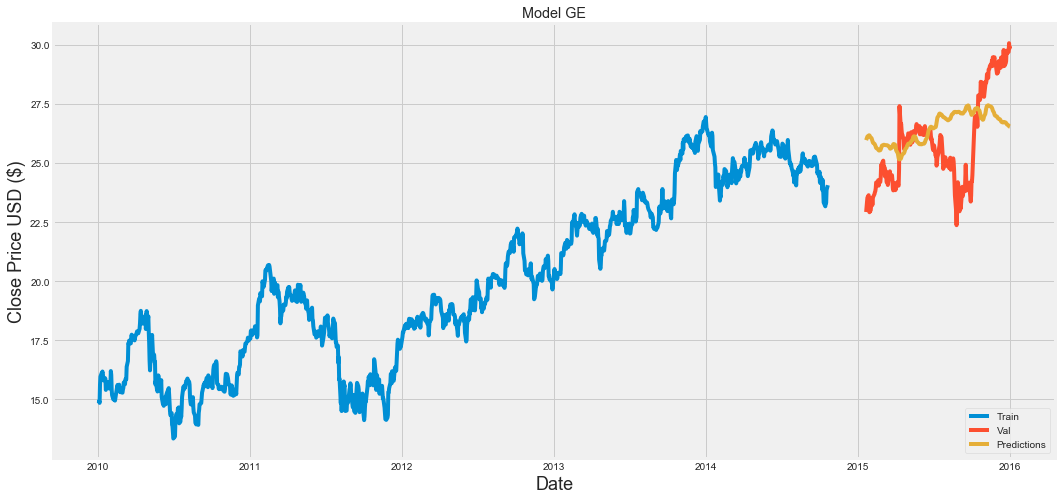

Ticker:  GE
LSTM target is:  Close
LSTM features are:  ['Close', '2 YR', '30 YR', 'Bullish', 'Bearish', 'unemployment', 'gdp', 'cpi', 'Sector_Close']
lookback is:  20
lookahead is:  60
years_window is:  2
length of test window:  319
normalization method:  min_max
output table:  C:\personal\karma_stocks_2021\stock_investigation\output\summary20210406-222541.csv
 
Notebook execution duration:  0:01:15.887449
close_threshold:  0.01
timeframe controlled by master_start and master_end:  True
beginning of timeframe:  2010-01-01
end of timeframe:  2016-01-01
proportion of timeframe for training:  0.8
normalized stats
  ticker  total deviation  avg deviation  max deviation  min deviation  \
0     GE          15.1251          1.637         0.1847         0.0002   

  proportion good days  
0                7.02%  


c:\users\ryanm\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [949]:
# Plot the data

summary_df = pd.DataFrame(columns=['ticker','total deviation','avg deviation','max deviation','min deviation','proportion good days'])
for company in tech_list:
    print(" ")
    print("starting output loop for ticker: ",company)
    summary_dict = {}
    train = data[company][:training_data_len[company]]
    #valid = data[company][training_data_len:]
    valid = data[company][training_data_len[company]+look_ahead_dict[company]:]
    #train = np.reshape(train,(train.shape[0],1))
    #valid = np.reshape(valid,(valid.shape[0],1))
    print("train shape ",train.shape)
    print("valid shape ",valid.shape)
    print("predictions[company] shape ",predictions[company].shape)
    print("key dimension predictions[company].shape[0]-look_ahead: ", str(predictions[company].shape[0]-look_ahead_dict[company]))
    print("things you want ",str(predictions[company].shape[0]-look_ahead_dict[company]))
    valid['Predictions'] = predictions[company][:predictions[company].shape[0]-look_ahead_dict[company]]
    # Visualize the data
    plt.figure(figsize=(16,8))
    plt.title('Model'+" "+company)
    plt.xlabel('Date', fontsize=18)
    plt.ylabel(lstm_target+' Price USD ($)', fontsize=18)
    plt.plot(train[lstm_target])
    plt.plot(valid[[lstm_target, 'Predictions']])
    plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
    plt.show()
    print("Ticker: ",company)
    print("LSTM target is: ",lstm_target)
    print("LSTM features are: ",lstm_feature_list)
    print("lookback is: ",str(look_back))
    print("lookahead is: ",str(look_ahead_dict[company]))
    print("years_window is: ",str(years_window))
    print("length of test window: ",len(test_data))
    if min_max_norm:
        norm = "min_max"
    else:
        norm = "standardization"
    print("normalization method: ",norm)
    # df[df > 1.0].count()
    # ['ticker','total error','avg error','max error','proportion good days']
    valid['error'] = valid[lstm_target] - valid['Predictions']
    summary_dict['ticker'] = company
    average_cost = valid['Close'].abs().mean()
    summary_dict['total deviation'] = round(valid['error'].abs().sum()/average_cost,report_round)
    summary_dict['avg deviation'] = round(valid['error'].abs().mean(),report_round)
    summary_dict['max deviation'] = round(valid['error'].abs().max()/average_cost,report_round)
    summary_dict['min deviation'] = round(valid['error'].abs().min()/average_cost,report_round)
    summary_dict['proportion good days'] = str(round((valid['error'][valid['error'].abs()/average_cost <= close_threshold].count()/predictions[company].shape[0])*100,2))+'%'
    summary_df = summary_df.append(summary_dict , ignore_index=True)
    # df['var3'] = pd.Series(["{0:.2f}%".format(val * 100) for val in df['var3']], index = df.index)
    #summary_df['proportion good days'] = pd.Series(["{0:.2f}%".format(val) for val in summary_df['proportion good days']],index=summary_df.index)
str_date = datetime.now().strftime("%Y%m%d-%H%M%S")
file_name = os.path.join(get_path(),"summary"+str_date+".csv")
print("output table: ",file_name)
summary_df.to_csv(file_name,index=False)
print(" ")
print("Notebook execution duration: ",str(datetime.now() - start_timestamp))
print("close_threshold: ",close_threshold)
print("timeframe controlled by master_start and master_end: ", str(master_date_mode))
if master_date_mode:
    print_start = start
    print_end = end
else:
    print_start = start.strftime("%Y-%m-%d")
    print_end = end.strftime("%Y-%m-%d")
print("beginning of timeframe: ",print_start)
print("end of timeframe: ",print_end)
print("proportion of timeframe for training: ", str(training_proportion))
print("normalized stats")
print(summary_df)

In [950]:
#
# total deviation = sum of difference between actual price and prediction, normalized by average cost
# avg deviation = average difference between actual price and prediction
# max deviation = highest difference between actual price and prediction, normalized by average cost
# proportion good days = proportion of days where difference between actual price and prediction (normalized by avg cost)
# was less than close_threshold value in config file

summary_df.head()

,ticker,total deviation,avg deviation,max deviation,min deviation,proportion good days
0,GE,15.1251,1.637,0.1847,0.0002,7.02%
